In this notebook, contains all the code necessary to process the in-vivo analysis. A python file version of this notebook can be found in the code folder.

Importing relevant modules:

In [1]:
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu
from functions import nls_fit_tensor
import time
%matplotlib inline

Downloading data...

In [2]:
fetch_cenir_multib(with_raw=False)

bvals = [200, 400, 1000, 2000]

img, gtab = read_cenir_multib(bvals)

data = img.get_data()

affine = img.get_affine()

Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\Rafael\.dipy\cenir_multib 


Estimate a brain mask...

In [3]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

Fitting the free water DTI model...

In [4]:
t0 = time.time()
fw_params = nls_fit_tensor(gtab, data, mask)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 2530.262000 seconds to run


C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 900.
  warnings.warn(errors[info][0], RuntimeWarning)


Compute tensor statistic from the fitted parameters...

In [5]:
evals = fw_params[..., :3]
FA = dti.fractional_anisotropy(evals)
MD = dti.mean_diffusivity(evals)
F = fw_params[..., 12]

Compute standard DTI for comparison...

In [6]:
dtimodel = dti.TensorModel(gtab)

dtifit = dtimodel.fit(data, mask=mask)

dti_FA = dtifit.fa
dti_MD = dtifit.md

Plot data for a axial slice of the data ...

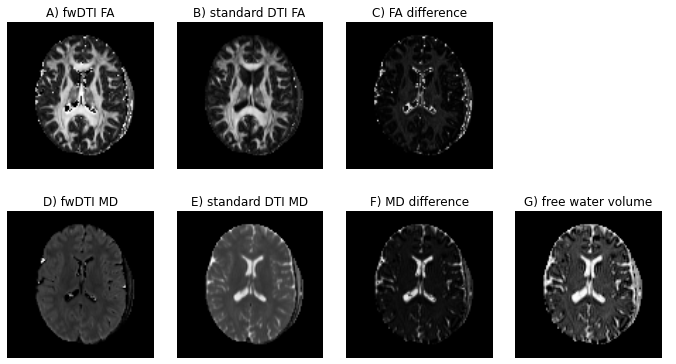

In [7]:
axial_slice = 40

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

ax.flat[3].axis('off')

ax.flat[4].imshow(MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[4].set_title('D) fwDTI MD')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[5].set_title('E) standard DTI MD')

MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice])
ax.flat[6].imshow(MDdiff.T, origin='lower', cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[6].set_title('F) MD difference')

ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')

plt.show()
fig1.savefig('In_vivo_free_water_DTI_and_standard_DTI_measures.png')